## Data pipeline with Keras and tf.data

In [1]:

import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Model



### tf.keras

  
#### The LSUN Dataset

In this assignment, we will use the [LSUN dataset](https://www.yf.io/p/lsun), which is a large-scale image dataset with 10 scene and 20 object categories. A subset of the LSUN dataset has been chosen,  including the `church_outdoor`, `classroom` and `conference_room` images. For more information, please check:

* F. Yu, A. Seff, Y. Zhang, S. Song, T. Funkhouser and J. Xia. "LSUN: Construction of a Large-scale Image Dataset using Deep Learning with Humans in the Loop". arXiv:1506.03365, 10 Jun 2015 

Our goal is to use the Keras preprocessing tools to construct a data pipeline to train a neural network and to classify the images into the three classes.

In [2]:
train_dir = 'data/lsun/train'
valid_dir = 'data/lsun/valid'
test_dir = 'data/lsun/test'

#### data generator with the ImageDataGenerator class

In [3]:

def get_ImageDataGenerator():
    """
    The function returns an instance of the ImageDataGenerator class, which rescales the images.
    """
    image_gen = ImageDataGenerator(rescale = (1/255.))
    
    return image_gen
    

In [4]:
# Call the function to get an ImageDataGenerator as specified

image_gen = get_ImageDataGenerator()

We now write a function that returns a generator object yielding batches of images and labels from the training and test set directories, with following properties:

* Generates batches of size 20.
* Resizes the images to 64 x 64 x 3.
* Returns one-hot vectors for labels. These are encoded as follows:
    * `classroom` $\rightarrow$ `[1., 0., 0.]`
    * `conference_room` $\rightarrow$ `[0., 1., 0.]`
    * `church_outdoor` $\rightarrow$ `[0., 0., 1.]`

In [5]:
def get_generator(image_data_generator, directory, seed=None):
    """
    The function takes an ImageDataGenerator object in the first argument and a 
    directory path in the second argument.
    """
    classes = ['classroom', 'conference_room', 'church_outdoor']
    
    generator = image_data_generator.flow_from_directory(directory,
                                                        batch_size = 20,
                                                        classes = classes,
                                                        target_size = (64,64),
                                                        shuffle = True,
                                                        seed = seed)
    
    return generator
    

In [6]:
# Define training and validation generators

train_generator = get_generator(image_gen, train_dir)
valid_generator = get_generator(image_gen, valid_dir)

Found 300 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


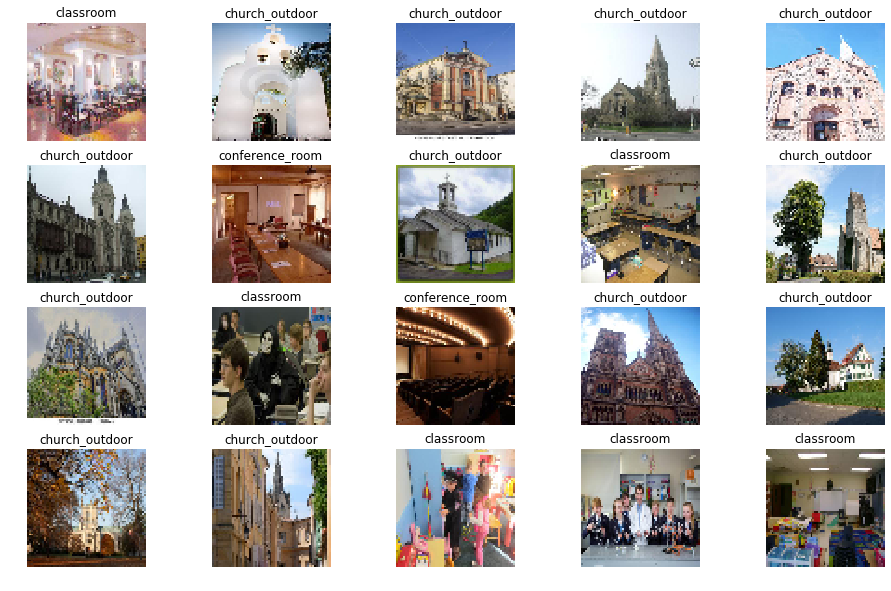

In [7]:
# Display a few images and labels

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])
lsun_classes = ['classroom', 'conference_room', 'church_outdoor']

plt.figure(figsize=(16,10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [8]:
# Reset the training generator

train_generator = get_generator(image_gen, train_dir)

Found 300 images belonging to 3 classes.


#### Build the neural network model

We will now build and compile a convolutional neural network classifier, using the functional API.

In [9]:
def get_model(input_shape):
    """
    The function should build and compile a CNN model, and returns the compiled model.
    """
    input_layer = Input(input_shape)
    h = Conv2D(filters = 8, kernel_size = (8,8), padding = 'same', activation = 'relu')(input_layer)
    h = MaxPooling2D(pool_size = (2,2))(h)
    h = Conv2D(filters = 4, kernel_size = (4,4), padding = 'same', activation = 'relu')(h)
    h = MaxPooling2D(pool_size = (2,2))(h)
    h = Flatten()(h)
    h = Dense(units = 16, activation = 'relu')(h)
    output_layer = Dense(units = 3, activation = 'softmax')(h)
    
    model = Model(inputs = input_layer, outputs = output_layer)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)
    
    model.compile(optimizer = opt,
                 loss = 'categorical_crossentropy',
                 metrics = ['categorical_accuracy'])
    
    return model


In [10]:
# Build and compile the model, print the model summary

lsun_model = get_model((64, 64, 3))
lsun_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         1544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         516       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400 

In [11]:
def train_model(model, train_gen, valid_gen, epochs):
    """
    This function should define the callback objects of early stopping and learning rate reduction.
    Trains the model with the given callbacks and returns the training history.
    """
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10)
    
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                             factor = 0.5, 
                                                             min_lr = 0.0001)
    
    
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    
    history = model.fit_generator(train_gen, validation_data = valid_gen, 
                        steps_per_epoch = train_steps_per_epoch, epochs = epochs,
                       callbacks = [early_stopping, learning_rate_reduction])
    
    
    return history


In [12]:
# Train the model

history = train_model(lsun_model, train_generator, valid_generator, epochs=50)

Epoch 1/50
15/15 [==============================] - 11s 762ms/step - loss: 1.1044 - categorical_accuracy: 0.3033 - val_loss: 1.0912 - val_categorical_accuracy: 0.3667
Epoch 2/50
15/15 [==============================] - 10s 699ms/step - loss: 1.0694 - categorical_accuracy: 0.4833 - val_loss: 1.0754 - val_categorical_accuracy: 0.4417
Epoch 3/50
15/15 [==============================] - 10s 666ms/step - loss: 1.0471 - categorical_accuracy: 0.4367 - val_loss: 1.0483 - val_categorical_accuracy: 0.4000
Epoch 4/50
15/15 [==============================] - 10s 673ms/step - loss: 0.9926 - categorical_accuracy: 0.5433 - val_loss: 1.0057 - val_categorical_accuracy: 0.4583
Epoch 5/50
15/15 [==============================] - 10s 693ms/step - loss: 0.9297 - categorical_accuracy: 0.5933 - val_loss: 0.9787 - val_categorical_accuracy: 0.5667
Epoch 6/50
15/15 [==============================] - 10s 700ms/step - loss: 0.8667 - categorical_accuracy: 0.6633 - val_loss: 0.9245 - val_categorical_accuracy: 0.525

15/15 [==============================] - 11s 707ms/step - loss: 0.4391 - categorical_accuracy: 0.8100 - val_loss: 0.8710 - val_categorical_accuracy: 0.6250
Epoch 20/50
15/15 [==============================] - 11s 709ms/step - loss: 0.4260 - categorical_accuracy: 0.8233 - val_loss: 0.9439 - val_categorical_accuracy: 0.6083
Epoch 21/50
15/15 [==============================] - 11s 717ms/step - loss: 0.3763 - categorical_accuracy: 0.8500 - val_loss: 0.8652 - val_categorical_accuracy: 0.6250
Epoch 22/50
15/15 [==============================] - 11s 733ms/step - loss: 0.3351 - categorical_accuracy: 0.8767 - val_loss: 0.9009 - val_categorical_accuracy: 0.6333
Epoch 23/50
15/15 [==============================] - 10s 700ms/step - loss: 0.3287 - categorical_accuracy: 0.8900 - val_loss: 0.8991 - val_categorical_accuracy: 0.5917
Epoch 24/50
15/15 [==============================] - 11s 733ms/step - loss: 0.3235 - categorical_accuracy: 0.8933 - val_loss: 0.9265 - val_categorical_accuracy: 0.6250
Epoc

15/15 [==============================] - 11s 727ms/step - loss: 0.2369 - categorical_accuracy: 0.9367 - val_loss: 0.9915 - val_categorical_accuracy: 0.6333
Epoch 39/50
15/15 [==============================] - 11s 700ms/step - loss: 0.2355 - categorical_accuracy: 0.9367 - val_loss: 0.9982 - val_categorical_accuracy: 0.6667
Epoch 40/50
15/15 [==============================] - 11s 720ms/step - loss: 0.2290 - categorical_accuracy: 0.9433 - val_loss: 0.9963 - val_categorical_accuracy: 0.6500
Epoch 41/50
15/15 [==============================] - 11s 757ms/step - loss: 0.2253 - categorical_accuracy: 0.9433 - val_loss: 1.0063 - val_categorical_accuracy: 0.6583
Epoch 42/50
15/15 [==============================] - 11s 703ms/step - loss: 0.2207 - categorical_accuracy: 0.9400 - val_loss: 1.0086 - val_categorical_accuracy: 0.6417
Epoch 43/50
15/15 [==============================] - 11s 727ms/step - loss: 0.2190 - categorical_accuracy: 0.9467 - val_loss: 1.0148 - val_categorical_accuracy: 0.6250
Epoc

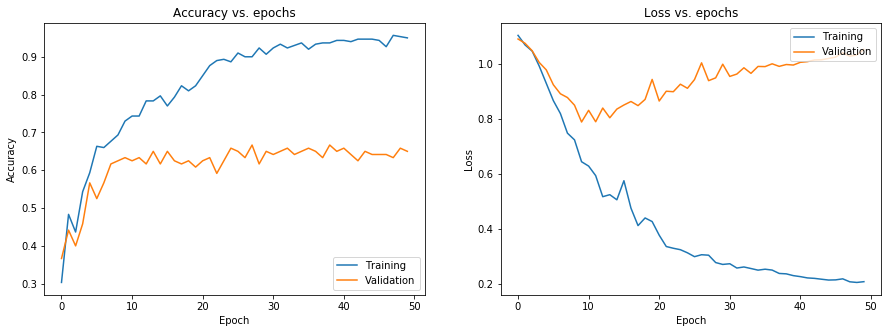

In [13]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Create a new data generator with data augmentation

We now write a function to create a new `ImageDataGenerator` object, which performs the following data preprocessing:

* Rescales by a factor of 1/255.
* Randomly rotates images by up to 30 degrees
* Randomly alters the brightness from the range (0.5, 1.5)
* Randomly flips images horizontally


In [14]:
def get_ImageDataGenerator_augmented():
    """
    The function should return an instance of the ImageDataGenerator class 
    with the above specifications.
    """
    
    img_generator = ImageDataGenerator(rescale = (1/255.),
                                       rotation_range = 30,
                                       brightness_range = (0.5, 1.5),
                                       horizontal_flip=True
                                      )
    
    return img_generator
    
    

In [15]:
# Get an ImageDataGenerator as specified

image_gen_aug = get_ImageDataGenerator_augmented()

In [16]:
# Define training and validation generators 

valid_generator_aug = get_generator(image_gen_aug, valid_dir)
train_generator_aug = get_generator(image_gen_aug, train_dir, seed=10)

Found 120 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [17]:
# Reset the original train_generator

train_generator = get_generator(image_gen, train_dir, seed=10)

Found 300 images belonging to 3 classes.


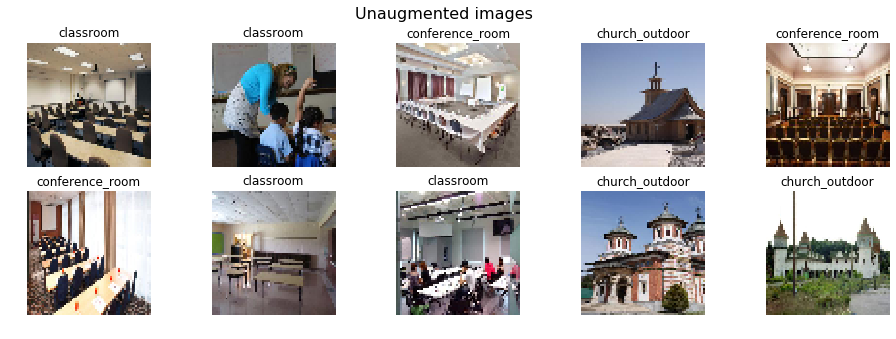

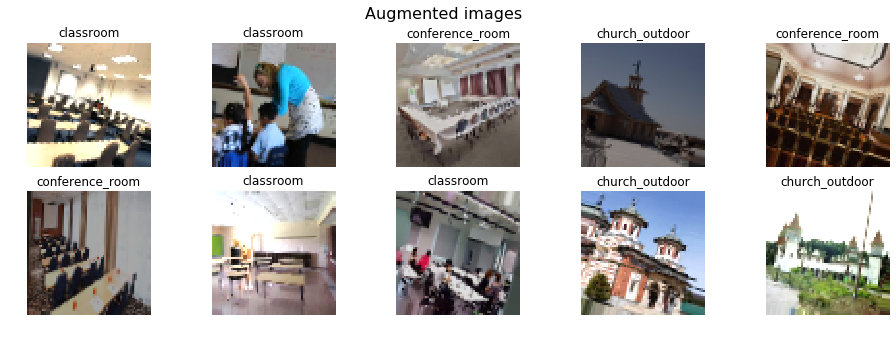

In [18]:
# Display a few images and labels from the non-augmented and augmented generators

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(lsun_classes[np.where(aug_batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [19]:
# Reset the augmented data generator

train_generator_aug = get_generator(image_gen_aug, train_dir)

Found 300 images belonging to 3 classes.


In [20]:
# Build and compile a new model

lsun_new_model = get_model((64, 64, 3))

In [21]:
# Train the model

history_augmented = train_model(lsun_new_model, train_generator_aug, valid_generator_aug, epochs=50)

Epoch 1/50
15/15 [==============================] - 12s 827ms/step - loss: 1.1139 - categorical_accuracy: 0.3733 - val_loss: 1.0748 - val_categorical_accuracy: 0.4000
Epoch 2/50
15/15 [==============================] - 12s 767ms/step - loss: 1.0723 - categorical_accuracy: 0.4433 - val_loss: 1.0334 - val_categorical_accuracy: 0.5417
Epoch 3/50
15/15 [==============================] - 12s 780ms/step - loss: 1.0362 - categorical_accuracy: 0.4733 - val_loss: 1.0223 - val_categorical_accuracy: 0.4667
Epoch 4/50
15/15 [==============================] - 12s 780ms/step - loss: 0.9994 - categorical_accuracy: 0.5133 - val_loss: 0.9875 - val_categorical_accuracy: 0.4917
Epoch 5/50
15/15 [==============================] - 12s 793ms/step - loss: 0.9543 - categorical_accuracy: 0.5967 - val_loss: 0.9323 - val_categorical_accuracy: 0.5250
Epoch 6/50
15/15 [==============================] - 11s 760ms/step - loss: 0.8711 - categorical_accuracy: 0.6300 - val_loss: 0.8477 - val_categorical_accuracy: 0.608

15/15 [==============================] - 11s 753ms/step - loss: 0.6672 - categorical_accuracy: 0.6900 - val_loss: 0.7300 - val_categorical_accuracy: 0.6583
Epoch 20/50
15/15 [==============================] - 11s 760ms/step - loss: 0.6774 - categorical_accuracy: 0.7000 - val_loss: 0.7285 - val_categorical_accuracy: 0.6583
Epoch 21/50
15/15 [==============================] - 11s 760ms/step - loss: 0.6571 - categorical_accuracy: 0.7433 - val_loss: 0.7760 - val_categorical_accuracy: 0.6333
Epoch 22/50
15/15 [==============================] - 12s 773ms/step - loss: 0.6731 - categorical_accuracy: 0.6667 - val_loss: 0.7876 - val_categorical_accuracy: 0.6417
Epoch 23/50
15/15 [==============================] - 11s 753ms/step - loss: 0.6796 - categorical_accuracy: 0.7167 - val_loss: 0.7761 - val_categorical_accuracy: 0.6083
Epoch 24/50
15/15 [==============================] - 12s 773ms/step - loss: 0.6748 - categorical_accuracy: 0.6967 - val_loss: 0.7297 - val_categorical_accuracy: 0.6500
Epoc

15/15 [==============================] - 11s 747ms/step - loss: 0.5629 - categorical_accuracy: 0.7600 - val_loss: 0.7898 - val_categorical_accuracy: 0.6667
Epoch 39/50
15/15 [==============================] - 11s 753ms/step - loss: 0.5783 - categorical_accuracy: 0.7400 - val_loss: 0.8022 - val_categorical_accuracy: 0.6583
Epoch 40/50
15/15 [==============================] - 12s 773ms/step - loss: 0.5315 - categorical_accuracy: 0.7733 - val_loss: 0.7530 - val_categorical_accuracy: 0.6417
Epoch 41/50
15/15 [==============================] - 12s 767ms/step - loss: 0.5673 - categorical_accuracy: 0.7667 - val_loss: 0.7578 - val_categorical_accuracy: 0.6833
Epoch 42/50
15/15 [==============================] - 11s 760ms/step - loss: 0.5660 - categorical_accuracy: 0.7500 - val_loss: 0.7392 - val_categorical_accuracy: 0.6583
Epoch 43/50
15/15 [==============================] - 11s 740ms/step - loss: 0.5831 - categorical_accuracy: 0.7567 - val_loss: 0.7080 - val_categorical_accuracy: 0.6500
Epoc

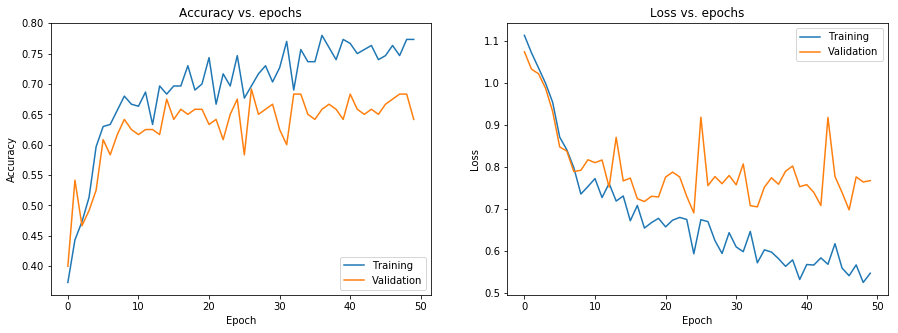

In [22]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_augmented.history['accuracy'])
    plt.plot(history_augmented.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history_augmented.history['acc'])
        plt.plot(history_augmented.history['val_acc'])
    except KeyError:
        plt.plot(history_augmented.history['categorical_accuracy'])
        plt.plot(history_augmented.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [23]:
# Get model predictions 

num_batches = 3
seed = 25
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
predictions = lsun_new_model.predict_generator(test_generator, steps=num_batches)

Found 300 images belonging to 3 classes.


Found 300 images belonging to 3 classes.
[26 14 27 55]


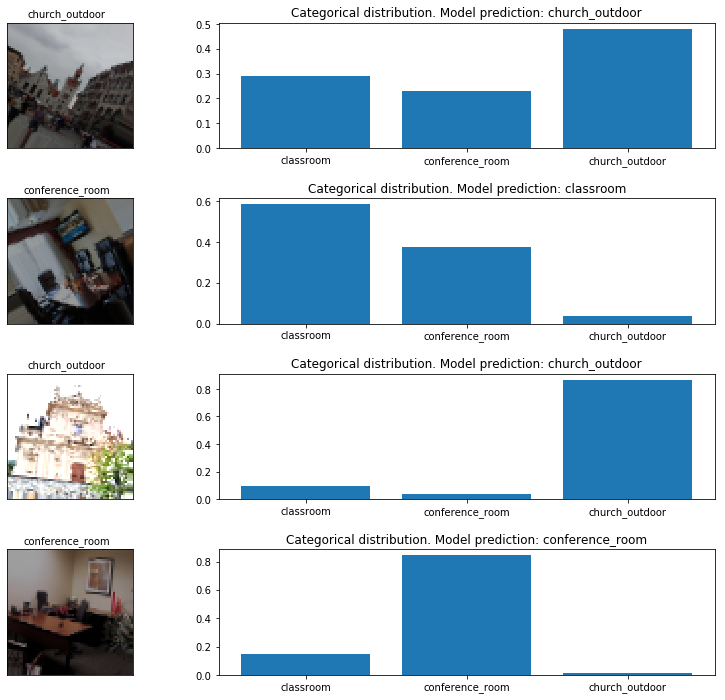

In [24]:
# Get images and ground truth labels
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
batches = []
for i in range(num_batches):
    batches.append(next(test_generator))
    
batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

# Randomly select images from the batch
inx = np.random.choice(predictions.shape[0], 4, replace=False)
print(inx)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for n, i in enumerate(inx):
    axes[n, 0].imshow(batch_images[i])
    axes[n, 0].get_xaxis().set_visible(False)
    axes[n, 0].get_yaxis().set_visible(False)
    axes[n, 0].text(30., -3.5, lsun_classes[np.where(batch_labels[i] == 1.)[0][0]], 
                    horizontalalignment='center')
    axes[n, 1].bar(np.arange(len(predictions[i])), predictions[i])
    axes[n, 1].set_xticks(np.arange(len(predictions[i])))
    axes[n, 1].set_xticklabels(lsun_classes)
    axes[n, 1].set_title(f"Categorical distribution. Model prediction: {lsun_classes[np.argmax(predictions[i])]}")
    
plt.show()

### Part 2: tf.data


#### The CIFAR-100 Dataset

In the second part, we will use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This image dataset has 100 classes with 500 training images and 100 test images per class. See below for more information:

* A. Krizhevsky. "Learning Multiple Layers of Features from Tiny Images". April 2009 

In [25]:
# Load the data

(train_data, train_labels), (test_data, test_labels) = cifar100.load_data(label_mode='fine')
with open('data/cifar100/cifar100_labels.json', 'r') as j:
    cifar_labels = json.load(j)

169009152/169001437 [==============================] - 4s 0us/step


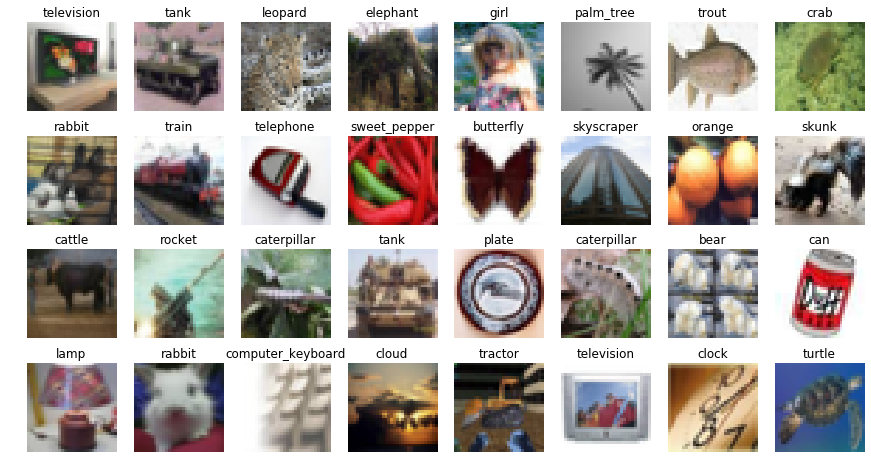

In [26]:
# Display a few images and labels

plt.figure(figsize=(15,8))
inx = np.random.choice(train_data.shape[0], 32, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(4, 8, n+1)
    plt.imshow(train_data[i])
    plt.title(cifar_labels[int(train_labels[i])])
    plt.axis('off')

In [27]:
def create_dataset(data, labels):
    """
    The function creates a tf.data.Dataset object with the cifar10 data and labels
    and returns it.
    """
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    return dataset
    

In [29]:
train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))


#### Filter the Dataset

We now write a function to filter the train and test datasets so that they only generate images that belong to a specified set of classes. 

In [30]:

def filter_classes(dataset, classes):
    """
    This function filters the dataset by only retaining dataset elements whose
    label belongs to one of the integers in the classes list.
    """
    def label_filter(image, label):
        
        y = tf.cast(label, tf.int32)
        z = tf.equal(y, classes)
        z2 = tf.math.reduce_any(z)
        
        return z2

    dataset = dataset.filter(label_filter)
    
    return dataset
    

In [31]:
# Filter the datasets using your function

cifar_classes = [0, 29, 99] 

train_dataset = filter_classes(train_dataset, cifar_classes)
test_dataset = filter_classes(test_dataset, cifar_classes)



#### Apply map functions to the Dataset

We now write two functions that use the `map` method to process the images and labels in the filtered dataset. 

The first function should one-hot encode the remaining labels so that we can train the network using a categorical cross entropy loss. The labels should be encoded according to the following:

* Class 0 maps to `[1., 0., 0.]`
* Class 29 maps to `[0., 1., 0.]`
* Class 99 maps to `[0., 0., 1.]`


In [32]:
def map_labels(dataset):
    """
    This function maps over the dataset to convert the label to a 
    one-hot vector according to the above specification.
    """
    def map_label(image, label):
        
        new_label = label
        
        if (label == tf.constant(0, dtype = tf.int64)):
            new_label = [1., 0., 0.]
        elif (label == tf.constant(29, dtype = tf.int64)):
            new_label = [0., 1., 0.]
        else: 
            new_label = [0., 0., 1.]
        
        return image, new_label

    
    dataset = dataset.map(map_label)
    
    return dataset   

In [33]:
train_dataset = map_labels(train_dataset)
test_dataset = map_labels(test_dataset)

Next, we write a function to process the images according to the following specification:

* Rescale the image pixel values by a factor of 1/255.
* Convert the colour images to black and white images 


In [34]:
def map_images(dataset):
    """
    This function maps over the dataset to process the image according to the 
    above specification.
    """
    
    def rescale_and_monochrome(image, label):
        
        single_color_image = tf.reduce_mean(image, axis = -1, keepdims = True)
        
        return single_color_image/255, label
    
    
    dataset = dataset.map(rescale_and_monochrome)
    
    return dataset

In [35]:
train_dataset_bw = map_images(train_dataset)
test_dataset_bw = map_images(test_dataset)

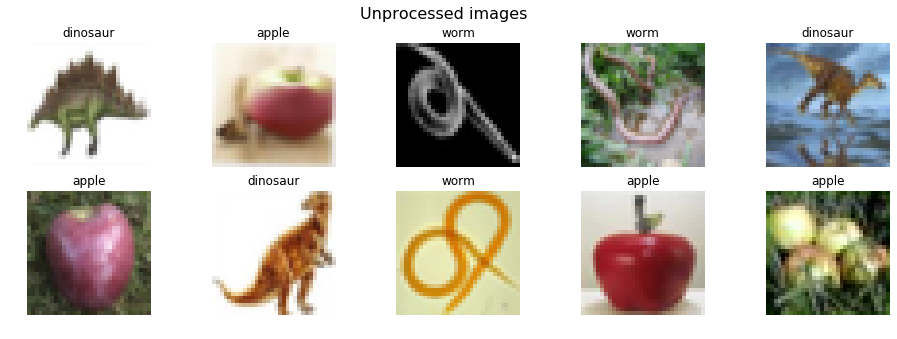

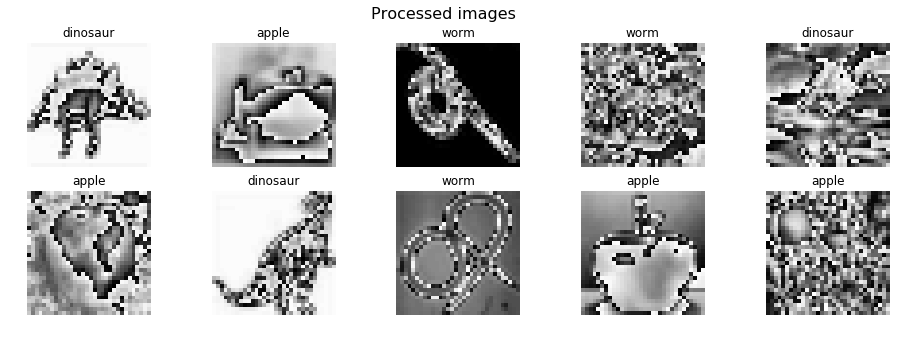

In [36]:
plt.figure(figsize=(16,5))
plt.suptitle("Unprocessed images", fontsize=16)
for n, elem in enumerate(train_dataset.take(10)):
    images, labels = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels == 1.)[0][0]]])
    plt.imshow(np.squeeze(images), cmap='gray')
    plt.axis('off')
    
plt.figure(figsize=(16,5))
plt.suptitle("Processed images", fontsize=16)
for n, elem in enumerate(train_dataset_bw.take(10)):
    images_bw, labels_bw = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels_bw == 1.)[0][0]]])
    plt.imshow(np.squeeze(images_bw), cmap='gray')
    plt.axis('off')

In [37]:
train_dataset_bw = train_dataset_bw.batch(10)
train_dataset_bw = train_dataset_bw.shuffle(100)

test_dataset_bw = test_dataset_bw.batch(10)
test_dataset_bw = test_dataset_bw.shuffle(100)

In [38]:
# Build and compile a new model with our original spec
    
cifar_model = get_model((32, 32, 1))

In [39]:
# Train the model

history = cifar_model.fit(train_dataset_bw, validation_data=test_dataset_bw, epochs=15)

Epoch 1/15
150/150 [==============================] - 22s 148ms/step - loss: 1.0948 - categorical_accuracy: 0.3767 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/15
150/150 [==============================] - 20s 135ms/step - loss: 1.0799 - categorical_accuracy: 0.4093 - val_loss: 1.0540 - val_categorical_accuracy: 0.5200
Epoch 3/15
150/150 [==============================] - 20s 133ms/step - loss: 1.0411 - categorical_accuracy: 0.5013 - val_loss: 0.9989 - val_categorical_accuracy: 0.4733
Epoch 4/15
150/150 [==============================] - 20s 133ms/step - loss: 0.9841 - categorical_accuracy: 0.5247 - val_loss: 0.9641 - val_categorical_accuracy: 0.5233
Epoch 5/15
150/150 [==============================] - 20s 133ms/step - loss: 0.9410 - categorical_accuracy: 0.5773 - val_loss: 0.8890 - val_categorical_accuracy: 0.6233
Epoch 6/15
150/150 [==============================] - 20s 133ms/step - loss: 0.8926 - categorical_accuracy: 0.5927 - val_loss: 0.8514 - val_categor

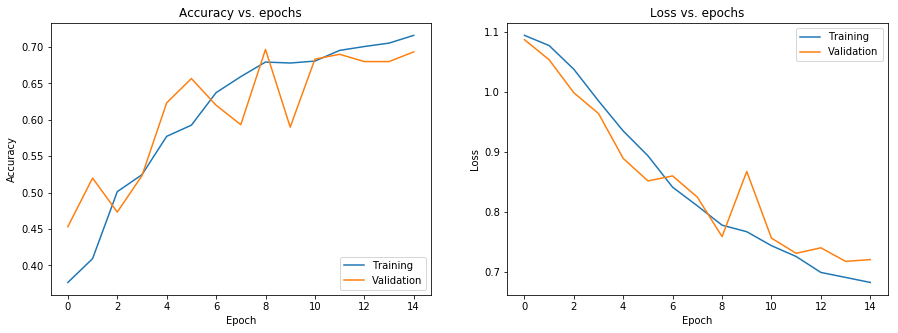

In [41]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [42]:
# Create an iterable from the batched test dataset

test_dataset = test_dataset.batch(10)
iter_test_dataset = iter(test_dataset)

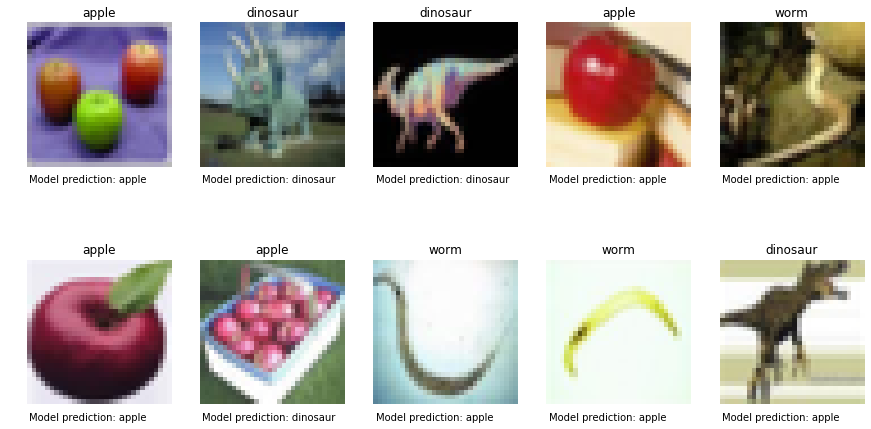

In [43]:
# Display model predictions

plt.figure(figsize=(15,8))
inx = np.random.choice(test_data.shape[0], 18, replace=False)
images, labels = next(iter_test_dataset)
probs = cifar_model(tf.reduce_mean(tf.cast(images, tf.float32), axis=-1, keepdims=True) / 255.)
preds = np.argmax(probs, axis=1)
for n in range(10):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(images[n])
    plt.title(cifar_labels[cifar_classes[np.where(labels[n].numpy() == 1.0)[0][0]]])
    plt.text(0, 35, "Model prediction: {}".format(cifar_labels[cifar_classes[preds[n]]]))
    plt.axis('off')